In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Projects/ai_for_medicine

Mounted at /content/drive/
/content/drive/MyDrive/Projects/ai_for_medicine


In [2]:
# !unzip Data/artrium_segmentation/processed.zip -d Data/artrium_segmentation

In [3]:
from pathlib import Path
import torch
import numpy as np
import imgaug
from tqdm.notebook import tqdm
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [6]:
class ArtriumDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.all_files = self.extract_files(root)
        self.transform = transform

    @staticmethod
    def extract_files(root):
        files = []
        for sub in root.glob("*"):
          slice_path = sub/"data"
          for slice in slice_path.glob("*.npy"):
            files.append(slice)
        return files

    @staticmethod
    def change_img_path_label_path(path):
      parts = list(path.parts)
      parts[parts.index("data")] = "masks"
      return Path(*parts)

    def augment(self, slice, mask):
      random_seed = torch.randint(0, 100000, (1,)).item()
      imgaug.seed(random_seed)

      mask = SegmentationMapsOnImage(mask, shape=mask.shape)
      slice_aug, mask_aug = self.transform(image=slice, segmentation_maps=mask)
      mask_aug = mask_aug.get_arr()
      return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_path_label_path(file_path)

        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.transform:
            slice, mask = self.augment(slice, mask)

        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)

In [7]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [8]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate = (-45, 45)),
    iaa.ElasticTransformation()
])

In [9]:
path = Path("Data/artrium_segmentation/processed/train")
dataset = ArtriumDataset(path, seq)

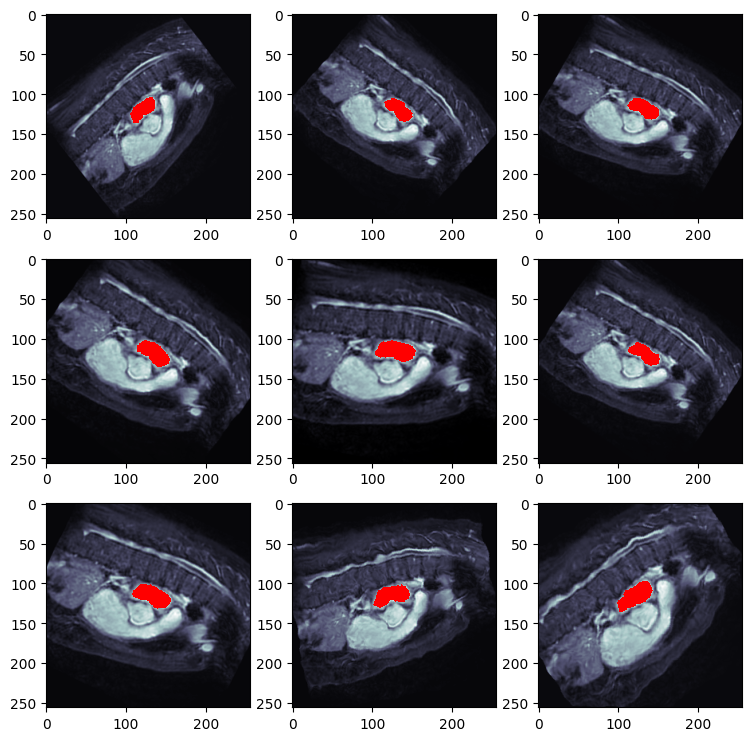

In [10]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
  for j in range(3):
    slice, mask = dataset[300]
    mask_ = np.ma.masked_where(mask == 0, mask)
    axis[i][j].imshow(slice[0], cmap="bone")
    axis[i][j].imshow(mask_[0], cmap="autumn")

In [11]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

In [12]:
class UNet(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = DoubleConv(1, 64)
    self.conv2 = DoubleConv(64, 128)
    self.conv3 = DoubleConv(128, 256)
    self.conv4 = DoubleConv(256, 512)

    self.conv5 = DoubleConv(512 + 256, 256)
    self.conv6 = DoubleConv(256 + 128, 128)
    self.conv7 = DoubleConv(128 + 64, 64)
    self.conv8 = torch.nn.Conv2d(64, 1, 1)

    self.maxpool = torch.nn.MaxPool2d(2)

  def forward(self, x):
    x1 = self.conv1(x)
    x1m = self.maxpool(x1)

    x2 = self.conv2(x1m)
    x2m = self.maxpool(x2)

    x3 = self.conv3(x2m)
    x3m = self.maxpool(x3)

    x4 = self.conv4(x3m)

    x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
    x5 = torch.cat([x5, x3], dim=1)
    x5 = self.conv5(x5)

    x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
    x6 = torch.cat([x6, x2], dim=1)
    x6 = self.conv6(x6)

    x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
    x7 = torch.cat([x7, x1], dim=1)
    x7 = self.conv7(x7)

    x8 = self.conv8(x7)

    return x8

In [13]:
model = UNet()

In [14]:
img = torch.randn(1, 1, 256, 256)
model(img).shape

torch.Size([1, 1, 256, 256])

### Training

In [15]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
               rotate = (-45, 45)),
    iaa.ElasticTransformation()
])

In [16]:
train_path = Path("Data/artrium_segmentation/processed/train")
val_path = Path("Data/artrium_segmentation/processed/val")

train_dataset = ArtriumDataset(train_path, seq)
val_dataset = ArtriumDataset(val_path, None)

In [17]:
batch_size = 16
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [18]:
class DiceLoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, pred, mask):
    pred = torch.flatten(pred)
    mask = torch.flatten(mask)

    intersection = (pred * mask).sum()
    union = pred.sum() + mask.sum() + 1e-8

    return 1 - ((2 * intersection) / union)

In [19]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [20]:
model = UNet().to(device)
criterion = DiceLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)

In [23]:
for epoch in range(30):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, masks in tqdm(train_loader):
        inputs, masks = inputs.to(device), masks.float().to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs).to(device)

        loss = criterion(outputs, masks)  # Adjust the output shape if necessary
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, masks in val_loader:
            inputs, masks = inputs.to(device), masks.float().to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs).to(device)
            loss = criterion(outputs, masks)

            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print('Finished Training')


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.9128, Val Loss: 0.5972


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.5795, Val Loss: 0.5351


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.5180, Val Loss: 0.4634


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.4735, Val Loss: 0.4256


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.4165, Val Loss: 0.3877


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.3708, Val Loss: 0.4257


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.3258, Val Loss: 0.3120


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.3096, Val Loss: 0.3769


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.2936, Val Loss: 0.2962


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.2512, Val Loss: 0.2589


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.2258, Val Loss: 0.2001


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.2211, Val Loss: 0.2237


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.2148, Val Loss: 0.2203


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.1831, Val Loss: 0.1972


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.1719, Val Loss: 0.2137


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.1590, Val Loss: 0.1547


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.1483, Val Loss: 0.1513


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.1521, Val Loss: 0.1413


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.1431, Val Loss: 0.1999


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.1457, Val Loss: 0.1565


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 21, Train Loss: 0.1306, Val Loss: 0.1442


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 22, Train Loss: 0.1222, Val Loss: 0.1530


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 23, Train Loss: 0.1151, Val Loss: 0.1569


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 24, Train Loss: 0.1185, Val Loss: 0.1565


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 25, Train Loss: 0.1176, Val Loss: 0.1501


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 26, Train Loss: 0.1238, Val Loss: 0.1401


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 27, Train Loss: 0.1153, Val Loss: 0.1376


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 28, Train Loss: 0.1088, Val Loss: 0.1260


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 29, Train Loss: 0.1020, Val Loss: 0.1606


  0%|          | 0/122 [00:00<?, ?it/s]

Epoch 30, Train Loss: 0.1035, Val Loss: 0.1153
Finished Training


In [24]:
model_save_path = 'models/artrium_segmentation_UNet.pth'
torch.save(model.state_dict(), model_save_path)

In [26]:
model.load_state_dict(torch.load('models/artrium_segmentation_UNet.pth'))

<All keys matched successfully>

In [30]:
# !pip install celluloid

In [29]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [32]:
preds = []
labels = []

for inputs, mask in tqdm(val_dataset):
    inputs = torch.tensor(inputs).to(device).unsqueeze(0)

    with torch.no_grad():
      pred = model(inputs)
    pred = torch.sigmoid(pred).to(device)

    preds.append(pred.cpu().numpy())
    labels.append(mask)

pred = np.array(preds)
labels = np.array(labels)

  0%|          | 0/320 [00:00<?, ?it/s]

In [34]:
loss = DiceLoss()
1 - loss(torch.from_numpy(pred), torch.from_numpy(labels))

tensor(0.8885)

In [50]:
subject = "Data/artrium_segmentation/la_002.nii.gz"
subject_mri = nib.load(subject).get_fdata()
subject_mri.shape

(320, 320, 140)

In [51]:
def normalize_data(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [52]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize_data(subject_mri))

In [53]:
preds = []

for i in range(standardized_scan.shape[-1]):
  slice = standardized_scan[:, :, i]
  with torch.no_grad():
    pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
    pred = pred > 0.5
  preds.append(pred.cpu())

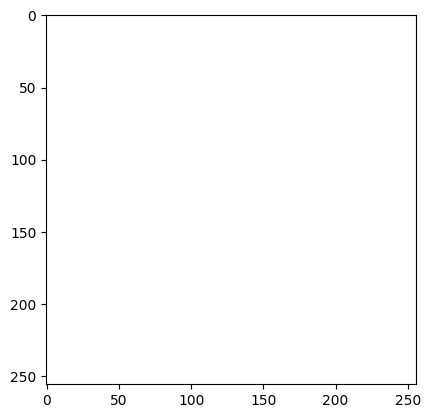

In [63]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
  plt.imshow(standardized_scan[:, :, i], cmap='bone')
  mask = np.ma.masked_where(preds[i] == 0, preds[i])
  plt.imshow(mask, alpha=1)
  camera.snap()

animation = camera.animate()

In [64]:
from IPython.display import HTML

HTML(animation.to_html5_video())